In [2]:
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

simplefilter("ignore")

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)
%config InlineBackend.figure_format = 'retina'


def plot_multistep(y, every=1, ax=None, palette_kwargs=None):
    palette_kwargs_ = dict(palette='husl', n_colors=16, desat=None)
    if palette_kwargs is not None:
        palette_kwargs_.update(palette_kwargs)
    palette = sns.color_palette(**palette_kwargs_)
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_prop_cycle(plt.cycler('color', palette))
    for date, preds in y[::every].iterrows():
        preds.index = pd.period_range(start=date, periods=len(preds))
        preds.plot(ax=ax)
    return ax


data_dir = Path("../input/ts-course-data")
flu_trends = pd.read_csv(data_dir / "flu-trends.csv")

In [3]:
flu_trends

,Week,AInfluenza,AcuteBronchitis,BodyTemperature,BraunThermoscan,BreakAFever,Bronchitis,ChestCold,ColdAndFlu,ColdOrFlu,...,TreatingTheFlu,TreatmentForFlu,TreatmentForTheFlu,Tussin,Tussionex,TypeAInfluenza,UpperRespiratory,WalkingPneumonia,WhatToDoIfYouHaveTheFlu,FluVisits
0,2009-06-29/2009-07-05,36,20,43,27,11,22,16,7,3,...,16,6,13,25,34,30,25,24,15,180
1,2009-07-06/2009-07-12,25,19,40,31,10,21,11,6,8,...,16,7,8,27,32,27,28,29,9,115
2,2009-07-13/2009-07-19,24,30,45,20,12,20,20,6,6,...,16,6,9,24,28,25,25,25,9,132
3,2009-07-20/2009-07-26,23,19,40,15,10,19,12,7,10,...,8,5,12,21,26,26,29,24,13,109
4,2009-07-27/2009-08-02,27,21,44,20,11,19,17,8,10,...,8,8,12,33,29,21,27,30,9,120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,2016-05-30/2016-06-05,5,46,50,29,31,37,33,17,9,...,7,3,6,30,17,4,53,41,7,90
362,2016-06-06/2016-06-12,5,47,49,21,24,36,35,19,8,...,5,3,5,33,18,3,52,42,6,55
363,2016-06-13/2016-06-19,4,47,48,21,22,34,32,15,8,...,6,2,6,37,16,3,54,38,3,33
364,2016-06-20/2016-06-26,3,47,51,26,24,31,35,15,7,...,3,3,6,32,20,3,52,35,5,27


In [9]:
type(flu_trends.Week[1])


str

In [10]:
type(pd.PeriodIndex(flu_trends.Week,freq='W')[1])

pandas._libs.tslibs.period.Period

In [11]:
flu_trends.set_index(
    pd.PeriodIndex(flu_trends.Week, freq="W"),
    inplace=True,
)
flu_trends.drop("Week", axis=1, inplace=True)
flu_trends

,AInfluenza,AcuteBronchitis,BodyTemperature,BraunThermoscan,BreakAFever,Bronchitis,ChestCold,ColdAndFlu,ColdOrFlu,ColdVersusFlu,...,TreatingTheFlu,TreatmentForFlu,TreatmentForTheFlu,Tussin,Tussionex,TypeAInfluenza,UpperRespiratory,WalkingPneumonia,WhatToDoIfYouHaveTheFlu,FluVisits
Week,,,,,,,,,,,,,,,,,,,,,
2009-06-29/2009-07-05,36,20,43,27,11,22,16,7,3,8,...,16,6,13,25,34,30,25,24,15,180
2009-07-06/2009-07-12,25,19,40,31,10,21,11,6,8,8,...,16,7,8,27,32,27,28,29,9,115
2009-07-13/2009-07-19,24,30,45,20,12,20,20,6,6,8,...,16,6,9,24,28,25,25,25,9,132
2009-07-20/2009-07-26,23,19,40,15,10,19,12,7,10,15,...,8,5,12,21,26,26,29,24,13,109
2009-07-27/2009-08-02,27,21,44,20,11,19,17,8,10,15,...,8,8,12,33,29,21,27,30,9,120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-05-30/2016-06-05,5,46,50,29,31,37,33,17,9,3,...,7,3,6,30,17,4,53,41,7,90
2016-06-06/2016-06-12,5,47,49,21,24,36,35,19,8,4,...,5,3,5,33,18,3,52,42,6,55
2016-06-13/2016-06-19,4,47,48,21,22,34,32,15,8,3,...,6,2,6,37,16,3,54,38,3,33


In [16]:
pd.concat([flu_trends.FluVisits,flu_trends.FluVisits.shift(-1)],axis=1)

,FluVisits,FluVisits
Week,,
2009-06-29/2009-07-05,180,115.0
2009-07-06/2009-07-12,115,132.0
2009-07-13/2009-07-19,132,109.0
2009-07-20/2009-07-26,109,120.0
2009-07-27/2009-08-02,120,115.0
...,...,...
2016-05-30/2016-06-05,90,55.0
2016-06-06/2016-06-12,55,33.0
2016-06-13/2016-06-19,33,27.0


In [17]:
def make_lags(ts, lags, lead_time=1):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(lead_time, lags + lead_time)
        },
        axis=1)


# Four weeks of lag features
y = flu_trends.FluVisits.copy()
X = make_lags(y, lags=4).fillna(0.0)


def make_multistep_target(ts, steps):
    return pd.concat(
        {f'y_step_{i + 1}': ts.shift(-i)
         for i in range(steps)},
        axis=1)


# Eight-week forecast
y = make_multistep_target(y, steps=8).dropna()


In [18]:
X

,y_lag_1,y_lag_2,y_lag_3,y_lag_4
Week,,,,
2009-06-29/2009-07-05,0.0,0.0,0.0,0.0
2009-07-06/2009-07-12,180.0,0.0,0.0,0.0
2009-07-13/2009-07-19,115.0,180.0,0.0,0.0
2009-07-20/2009-07-26,132.0,115.0,180.0,0.0
2009-07-27/2009-08-02,109.0,132.0,115.0,180.0
...,...,...,...,...
2016-05-30/2016-06-05,124.0,156.0,211.0,305.0
2016-06-06/2016-06-12,90.0,124.0,156.0,211.0
2016-06-13/2016-06-19,55.0,90.0,124.0,156.0


In [19]:
y

,y_step_1,y_step_2,y_step_3,y_step_4,y_step_5,y_step_6,y_step_7,y_step_8
Week,,,,,,,,
2009-06-29/2009-07-05,180,115.0,132.0,109.0,120.0,115.0,123.0,205.0
2009-07-06/2009-07-12,115,132.0,109.0,120.0,115.0,123.0,205.0,454.0
2009-07-13/2009-07-19,132,109.0,120.0,115.0,123.0,205.0,454.0,628.0
2009-07-20/2009-07-26,109,120.0,115.0,123.0,205.0,454.0,628.0,687.0
2009-07-27/2009-08-02,120,115.0,123.0,205.0,454.0,628.0,687.0,821.0
...,...,...,...,...,...,...,...,...
2016-04-11/2016-04-17,616,578.0,455.0,305.0,211.0,156.0,124.0,90.0
2016-04-18/2016-04-24,578,455.0,305.0,211.0,156.0,124.0,90.0,55.0
2016-04-25/2016-05-01,455,305.0,211.0,156.0,124.0,90.0,55.0,33.0


In [20]:
y, X = y.align(X, join='inner', axis=0)

,y_step_1,y_step_2,y_step_3,y_step_4,y_step_5,y_step_6,y_step_7,y_step_8
Week,,,,,,,,
2009-06-29/2009-07-05,180,115.0,132.0,109.0,120.0,115.0,123.0,205.0
2009-07-06/2009-07-12,115,132.0,109.0,120.0,115.0,123.0,205.0,454.0
2009-07-13/2009-07-19,132,109.0,120.0,115.0,123.0,205.0,454.0,628.0
2009-07-20/2009-07-26,109,120.0,115.0,123.0,205.0,454.0,628.0,687.0
2009-07-27/2009-08-02,120,115.0,123.0,205.0,454.0,628.0,687.0,821.0
...,...,...,...,...,...,...,...,...
2016-04-11/2016-04-17,616,578.0,455.0,305.0,211.0,156.0,124.0,90.0
2016-04-18/2016-04-24,578,455.0,305.0,211.0,156.0,124.0,90.0,55.0
2016-04-25/2016-05-01,455,305.0,211.0,156.0,124.0,90.0,55.0,33.0


## Multioutput Model

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

model = LinearRegression()
model.fit(X_train, y_train)

y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y.columns)
y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)

Train RMSE: 389.12
Test RMSE: 582.33


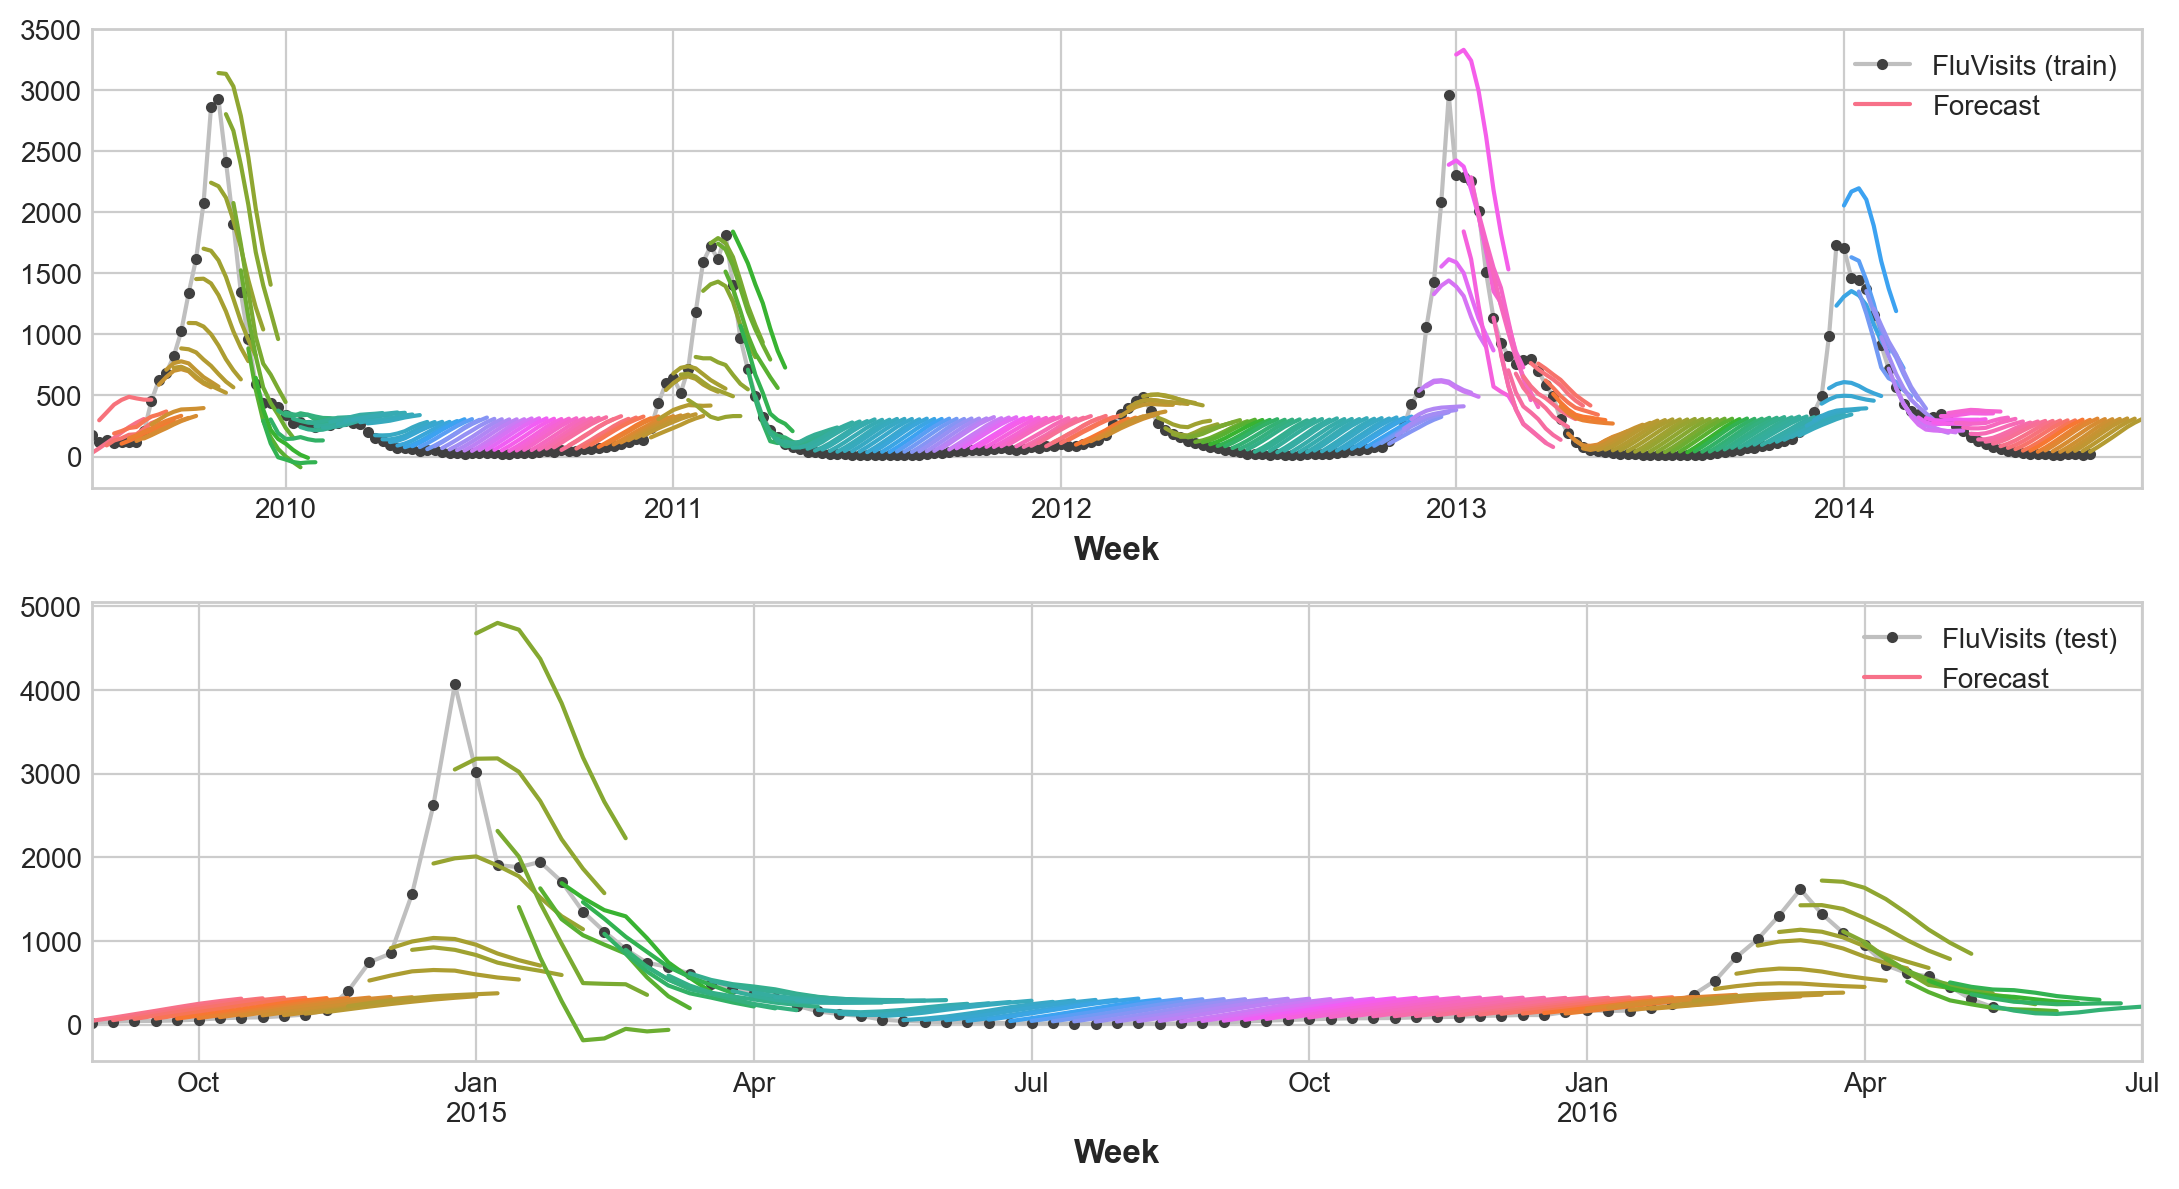

In [24]:
train_rmse = mean_squared_error(y_train, y_fit, squared=False)
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"Train RMSE: {train_rmse:.2f}\n" f"Test RMSE: {test_rmse:.2f}")

palette = dict(palette='husl', n_colors=64)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 6))
ax1 = flu_trends.FluVisits[y_fit.index].plot(**plot_params, ax=ax1)
ax1 = plot_multistep(y_fit, ax=ax1, palette_kwargs=palette)
_ = ax1.legend(['FluVisits (train)', 'Forecast'])
ax2 = flu_trends.FluVisits[y_pred.index].plot(**plot_params, ax=ax2)
ax2 = plot_multistep(y_pred, ax=ax2, palette_kwargs=palette)
_ = ax2.legend(['FluVisits (test)', 'Forecast'])

## Direct strategy

In [26]:
from sklearn.multioutput import MultiOutputRegressor

model = MultiOutputRegressor(XGBRegressor())
model.fit(X_train, y_train)

y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y.columns)
y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)

Train RMSE: 1.22
Test RMSE: 526.45


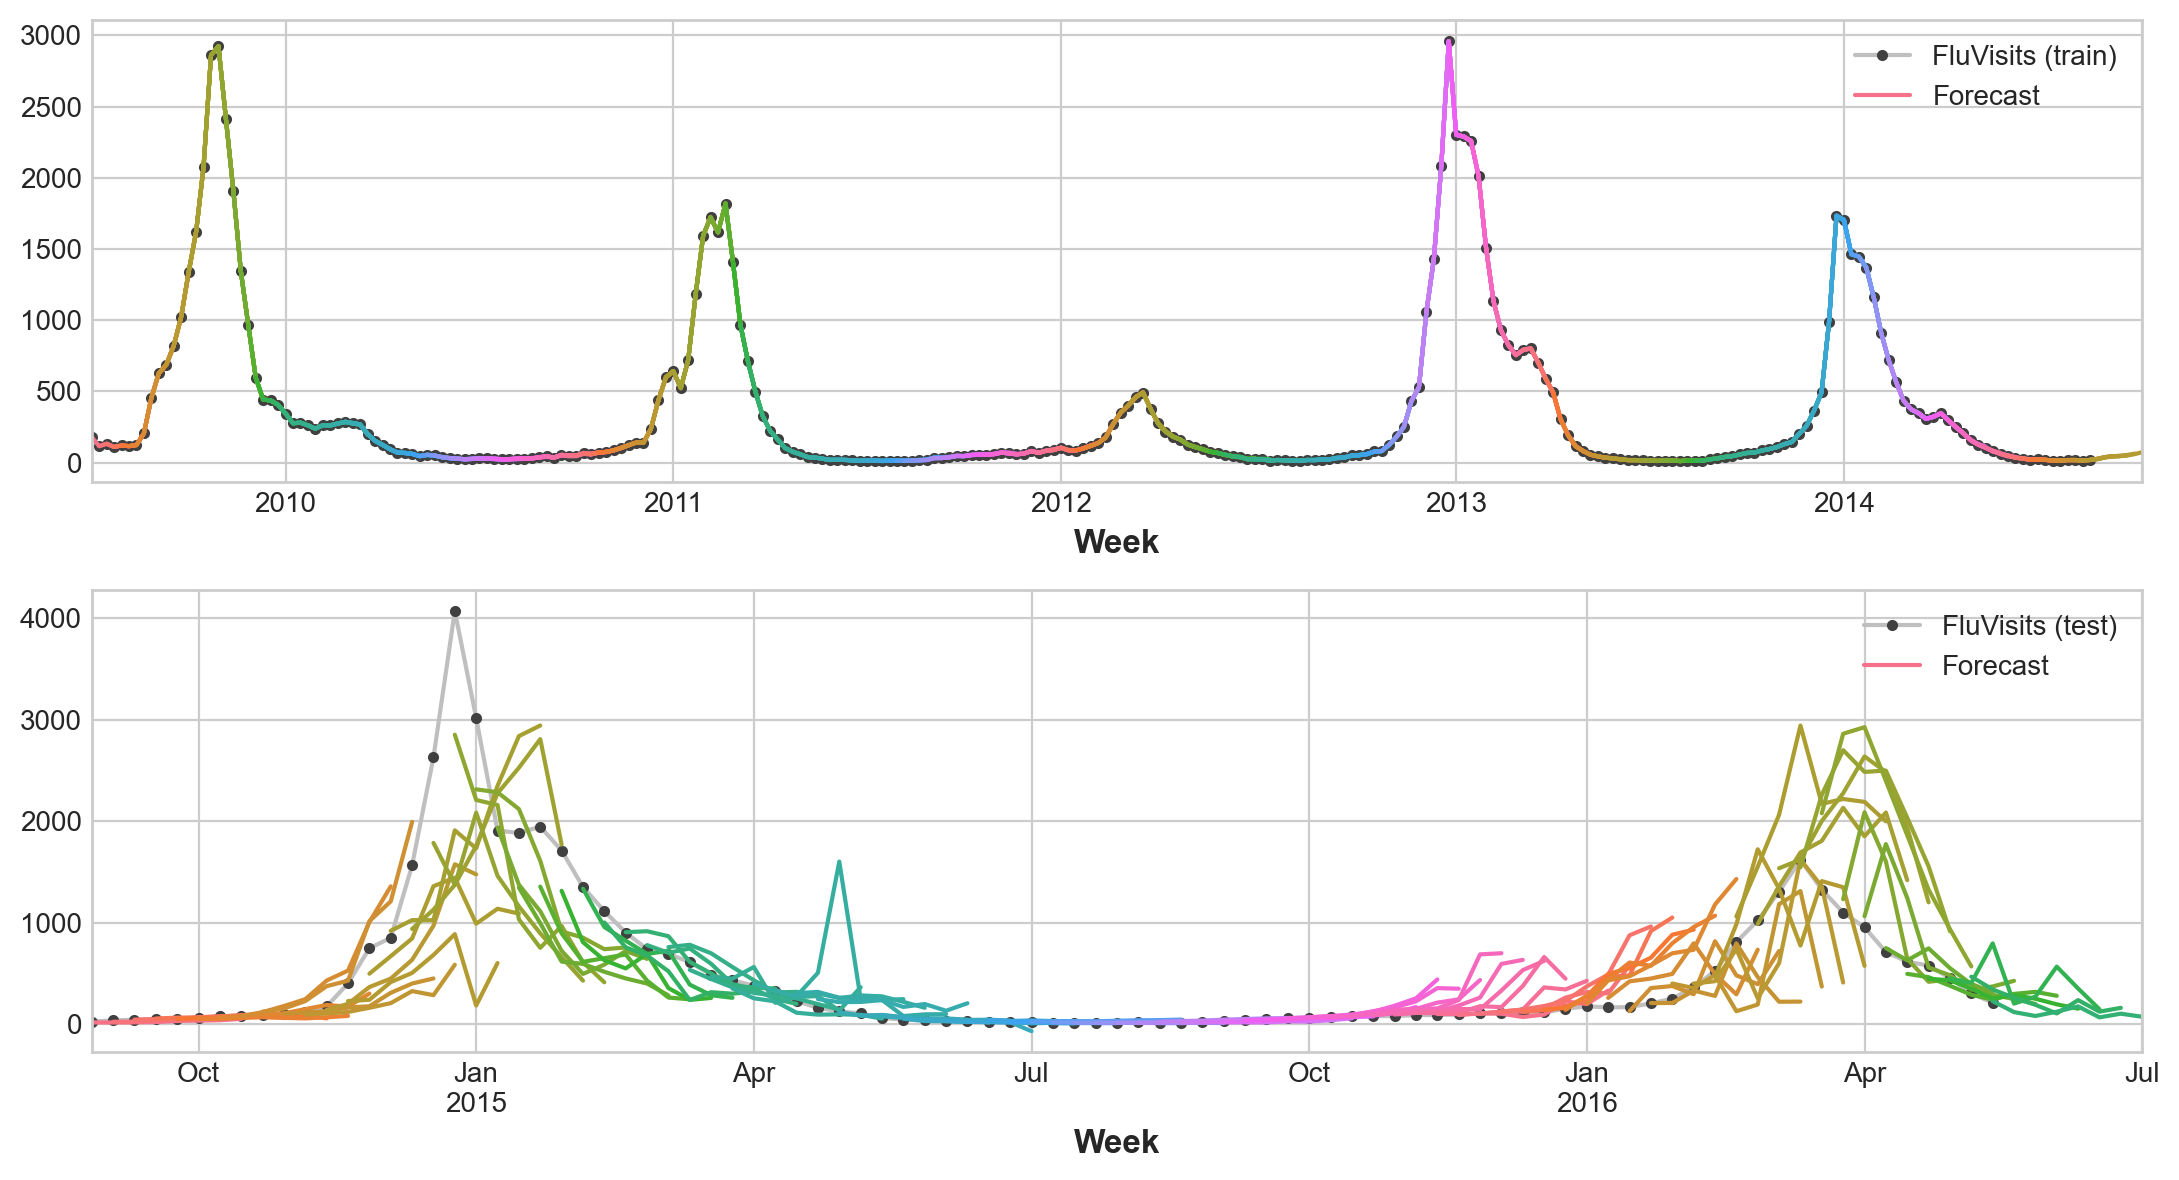

In [27]:
train_rmse = mean_squared_error(y_train, y_fit, squared=False)
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"Train RMSE: {train_rmse:.2f}\n" f"Test RMSE: {test_rmse:.2f}")

palette = dict(palette='husl', n_colors=64)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 6))
ax1 = flu_trends.FluVisits[y_fit.index].plot(**plot_params, ax=ax1)
ax1 = plot_multistep(y_fit, ax=ax1, palette_kwargs=palette)
_ = ax1.legend(['FluVisits (train)', 'Forecast'])
ax2 = flu_trends.FluVisits[y_pred.index].plot(**plot_params, ax=ax2)
ax2 = plot_multistep(y_pred, ax=ax2, palette_kwargs=palette)
_ = ax2.legend(['FluVisits (test)', 'Forecast'])

## DirRec

In [28]:
from sklearn.multioutput import RegressorChain
model = RegressorChain(XGBRegressor())
model.fit(X_train,y_train)

y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y.columns)
y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)

Train RMSE: 27.88
Test RMSE: 553.20


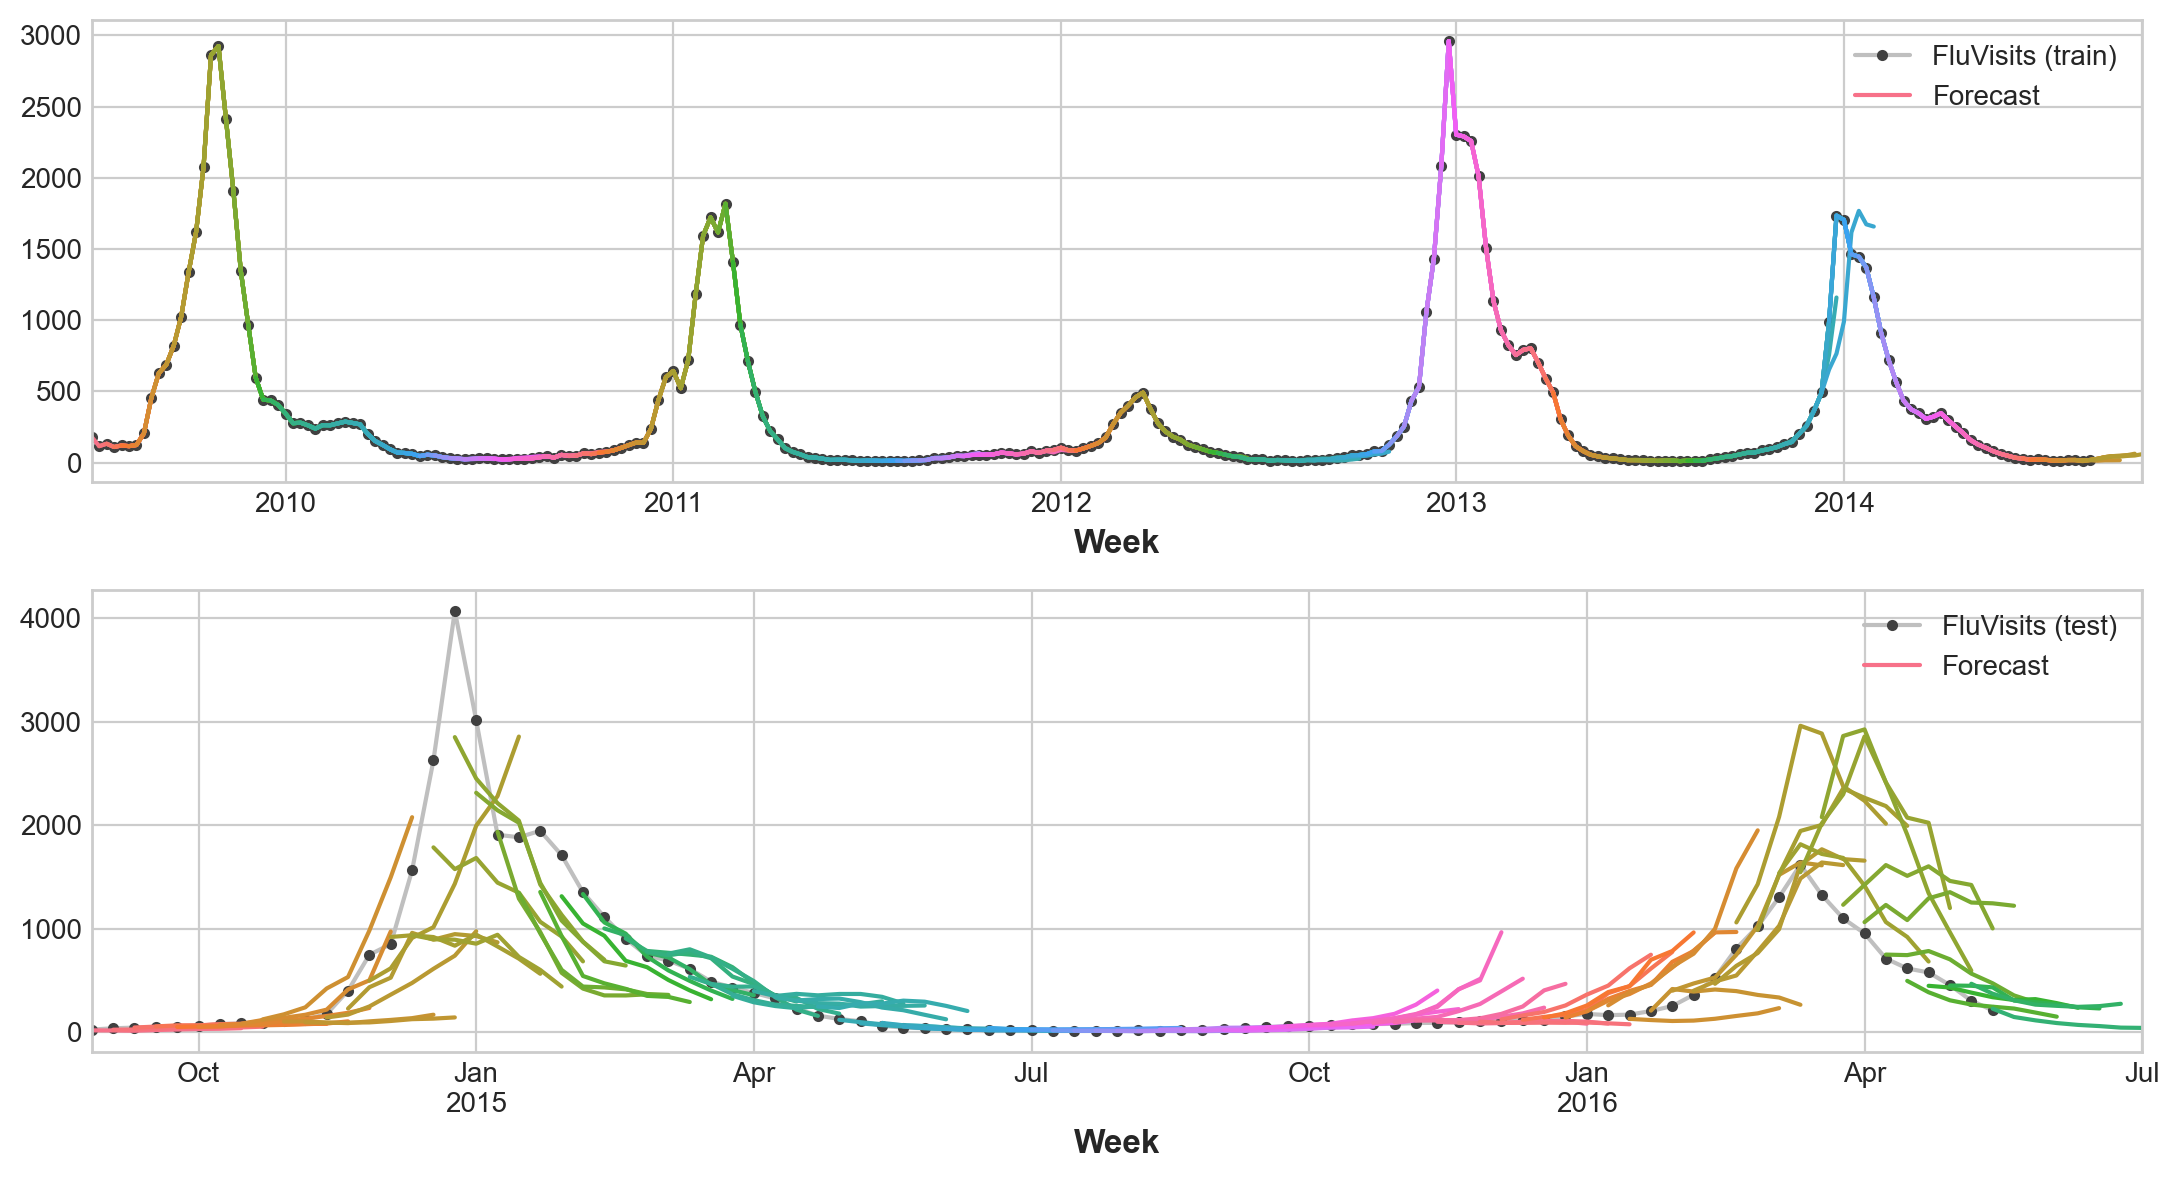

In [29]:
train_rmse = mean_squared_error(y_train, y_fit, squared=False)
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"Train RMSE: {train_rmse:.2f}\n" f"Test RMSE: {test_rmse:.2f}")

palette = dict(palette='husl', n_colors=64)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 6))
ax1 = flu_trends.FluVisits[y_fit.index].plot(**plot_params, ax=ax1)
ax1 = plot_multistep(y_fit, ax=ax1, palette_kwargs=palette)
_ = ax1.legend(['FluVisits (train)', 'Forecast'])
ax2 = flu_trends.FluVisits[y_pred.index].plot(**plot_params, ax=ax2)
ax2 = plot_multistep(y_pred, ax=ax2, palette_kwargs=palette)
_ = ax2.legend(['FluVisits (test)', 'Forecast'])